In [5]:
import joblib
outs = joblib.load("outputs/artifacts/algo1_outs_2025-05-22_1min_agreg.pkl")

/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/opt/anaconda3/envs/csiro_stem/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Epoch 1/100  Train NLL: 6.5468e+00  Test NLL: 3.2944e+00
Epoch 2/100  Train NLL: 5.4657e+00  Test NLL: 2.6343e+00
Epoch 3/100  Train NLL: 5.0003e+00  Test NLL: 2.4366e+00
Epoch 4/100  Train NLL: 4.7740e+00  Test NLL: 2.3331e+00
Epoch 5/100  Train NLL: 4.5746e+00  Test NLL: 2.2361e+00
Epoch 6/100  Train NLL: 4.3870e+00  Test NLL: 2.1446e+00
Epoch 7/100  Train NLL: 4.2067e+00  Test NLL: 2.0555e+00
Epoch 8/100  Train NLL: 4.0295e+00  Test NLL: 1.9669e+00
Epoch 9/100  Train NLL: 3.8525e+00  Test NLL: 1.8781e+00
Epoch 10/100  Train NLL: 3.6737e+00  Test NLL: 1.7878e+00
Epoch 11/100  Train NLL: 3.4920e+00  Test NLL: 1.6961e+00
Epoch 12/100  Train NLL: 3.3068e+00  Test NLL: 1.6024e+00
Epoch 13/100  Train NLL: 3.1180e+00  Test NLL: 1.5071e+00
Epoch 14/100  Train NLL: 2.9261e+00  Test NLL: 1.4097e+00
Epoch 15/100  Train NLL: 2.7300e+00  Test NLL: 1.3113e+00
Epoch 16/100  Train NLL: 2.5323e+00  Test NLL: 1.2109e+00
Epoch 17/100  Train NLL: 2.3313e+00  Test NLL: 1.1102e+00
Epoch 18/100  Train NLL

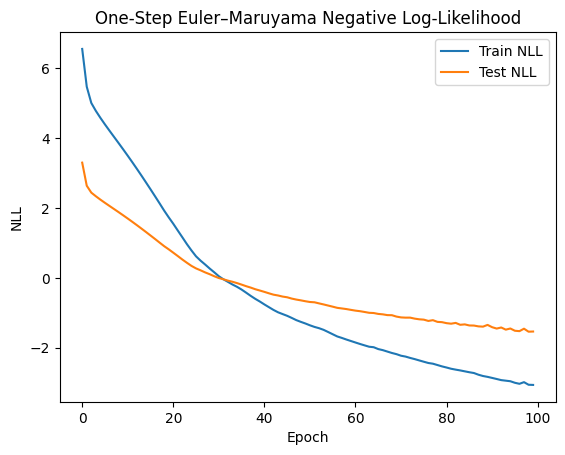

In [ ]:
from neural_sde.loss import likelihood_training
train_losses, test_losses, model, X_train = likelihood_training(
    outs,
    n_epochs=100,
    batch_size=48,
    lr=1e-4,
    data='xi'
)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_losses, label="Train NLL")
plt.plot(test_losses, label="Test NLL")
plt.title("One-Step Euler–Maruyama Negative Log-Likelihood")
plt.xlabel("Epoch")
plt.ylabel("NLL")
plt.legend()
plt.show()

Train Δt: pairs=1100  mean=60.00s  std=0.00s  median=60.00s
  quantiles (s): 0%=60.00, 1%=60.00, 5%=60.00, 25%=60.00, 50%=60.00, 75%=60.00, 95%=60.00, 99%=60.00, 100%=60.00
  frac(dt >   1s) = 100.00%
  frac(dt >   5s) = 100.00%
  frac(dt >  10s) = 100.00%
  frac(dt >  60s) =  0.00%
  frac(dt > 300s) =  0.00%
  frac(dt > 900s) =  0.00%
Test  Δt: pairs=339  mean=60.00s  std=0.00s  median=60.00s
  quantiles (s): 0%=60.00, 1%=60.00, 5%=60.00, 25%=60.00, 50%=60.00, 75%=60.00, 95%=60.00, 99%=60.00, 100%=60.00
  frac(dt >   1s) = 100.00%
  frac(dt >   5s) = 100.00%
  frac(dt >  10s) = 100.00%
  frac(dt >  60s) =  0.00%
  frac(dt > 300s) =  0.00%
  frac(dt > 900s) =  0.00%


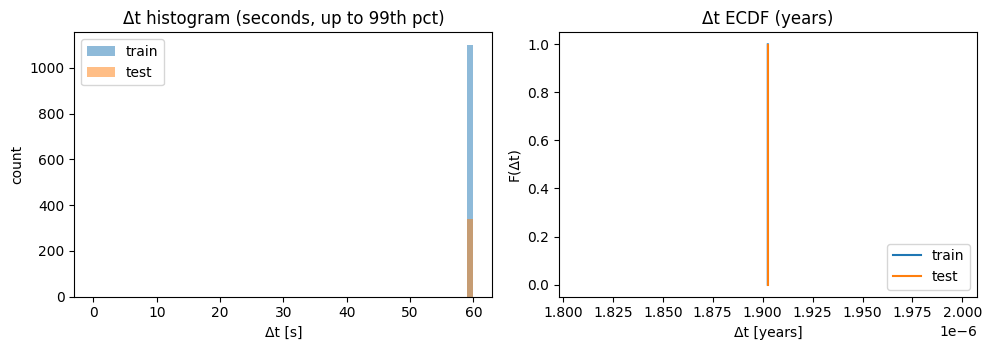

In [7]:
# Python
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sec_per_year = 365.0 * 24 * 3600

# 1) Build dt arrays (seconds and years)
tt_tr = pd.to_datetime(outs.C_train.index.values)  # [`pipeline.Algo1Outputs.C_train`](pipeline/algo1.py)
tt_te = pd.to_datetime(outs.C_test.index.values)   # [`pipeline.Algo1Outputs.C_test`](pipeline/algo1.py)

# Differences as Timedeltas, then robustly convert to NumPy float seconds
dt_tr_td = tt_tr[1:] - tt_tr[:-1]
dt_te_td = tt_te[1:] - tt_te[:-1]

dt_tr_s = np.asarray(pd.to_timedelta(dt_tr_td).total_seconds(), dtype=np.float64)
dt_te_s = np.asarray(pd.to_timedelta(dt_te_td).total_seconds(), dtype=np.float64)

dt_tr_y = dt_tr_s / sec_per_year
dt_te_y = dt_te_s / sec_per_year

# 2) Text summary
def summarize_dt(name, dt_s):
    dt_s = np.asarray(dt_s, dtype=np.float64)
    q = np.quantile(dt_s, [0,.01,.05,.25,.5,.75,.95,.99,1.0])
    print(f"{name}: pairs={dt_s.size}  mean={np.mean(dt_s):.2f}s  std={np.std(dt_s):.2f}s  median={q[4]:.2f}s")
    print(f"  quantiles (s): 0%={q[0]:.2f}, 1%={q[1]:.2f}, 5%={q[2]:.2f}, 25%={q[3]:.2f}, "
          f"50%={q[4]:.2f}, 75%={q[5]:.2f}, 95%={q[6]:.2f}, 99%={q[7]:.2f}, 100%={q[8]:.2f}")
    for thr in (1, 5, 10, 60, 300, 900):
        frac = float((dt_s > thr).mean())
        print(f"  frac(dt > {thr:>3}s) = {frac:6.2%}")

summarize_dt("Train Δt", dt_tr_s)
summarize_dt("Test  Δt", dt_te_s)

# 3) Plots: histogram (seconds) and ECDF
p99 = max(np.quantile(dt_tr_s, 0.99), np.quantile(dt_te_s, 0.99))
bins = np.linspace(0, p99, 60)

fig, axes = plt.subplots(1, 2, figsize=(10, 3.6))

# Histogram up to 99th percentile (seconds)
axes[0].hist(dt_tr_s, bins=bins, alpha=0.5, label="train")
axes[0].hist(dt_te_s, bins=bins, alpha=0.5, label="test")
axes[0].set_title("Δt histogram (seconds, up to 99th pct)")
axes[0].set_xlabel("Δt [s]"); axes[0].set_ylabel("count"); axes[0].legend()

# ECDF (years) for full range
def ecdf(x):
    x = np.sort(np.asarray(x, dtype=np.float64))
    y = np.linspace(0, 1, len(x), endpoint=False)
    return x, y

x_tr, y_tr = ecdf(dt_tr_y); x_te, y_te = ecdf(dt_te_y)
axes[1].plot(x_tr, y_tr, label="train")
axes[1].plot(x_te, y_te, label="test")
axes[1].set_title("Δt ECDF (years)")
axes[1].set_xlabel("Δt [years]"); axes[1].set_ylabel("F(Δt)"); axes[1].legend(loc="lower right")

plt.tight_layout(); plt.show()

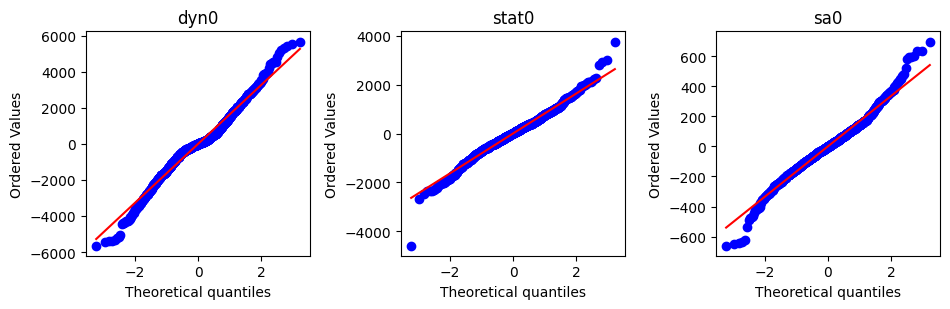

In [8]:
# In your neural_sde.ipynb after training
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from scipy import stats
from neural_sde.loss import build_xi_training_data  # -> [`neural_sde.loss.build_xi_training_data`](neural_sde/loss.py)

sde_model = model

# 1) In-sample factor matrix (columns = factors: dyn | stat | sa)
X_train, _, names = build_xi_training_data(outs)  # names like ["dyn0","dyn1",...,"stat0",...,"sa0",...]

# 2) Compute dt in years from training timestamps (align lengths)
tt = pd.to_datetime(outs.C_train.index.values)
sec_per_year = 365.0 * 24 * 3600
dt = np.asarray((tt[1:] - tt[:-1]).total_seconds(), dtype=np.float64) / sec_per_year

L = min(len(dt), X_train.shape[0]-1)

device = next(sde_model.parameters()).device
Y0 = torch.from_numpy(X_train[:L]).float().to(device)
Y1 = torch.from_numpy(X_train[1:L+1]).float().to(device)
dt_t = torch.from_numpy(dt[:L].copy()).float().unsqueeze(1).clamp_min(1e-12).to(device)

with torch.no_grad():
    mu  = sde_model.f(0.0, Y0)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 3) One-step standardized residuals under the trained SDE
#    ε_t = (x_{t+1} - x_t - f(x_t)Δt) / (g(x_t)√Δt)
with torch.no_grad():
    mu = sde_model.f(0.0, Y0)                        # [`neural_sde.nets.NeuralSDE.f`](neural_sde/nets.py)
    sig = sde_model.g(0.0, Y0).clamp_min(1e-9)       # [`neural_sde.nets.NeuralSDE.g`](neural_sde/nets.py)
    eps = (Y1 - Y0 - mu*dt_t) / (sig * torch.sqrt(dt_t))
resid = eps.cpu().numpy()

# 4) QQ plots per factor
d = resid.shape[1]
cols = 3
rows = int(np.ceil(d/cols))
fig, axes = plt.subplots(rows, cols, figsize=(cols*3.2, rows*3.2))
axes = axes.ravel()

for j in range(d):
    stats.probplot(resid[:, j], dist="norm", plot=axes[j])
    axes[j].set_title(names[j] if names else f"factor {j}")

for k in range(d, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()



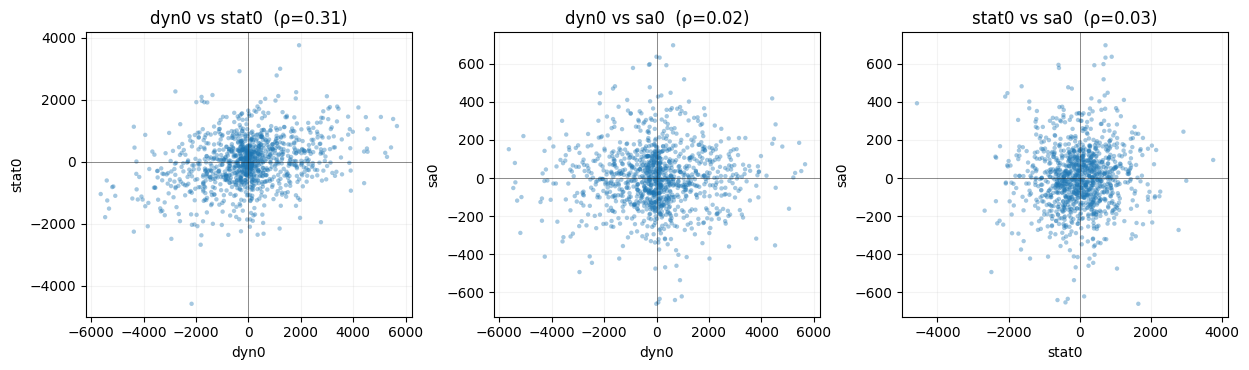

In [9]:
# Pairwise scatter plots of residuals
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
import math

R = np.asarray(resid, float)  # shape (T-1, d)
d = R.shape[1]
labels = names if (isinstance(names, (list, tuple)) and len(names)==d) else [f"f{j}" for j in range(d)]

pairs = list(combinations(range(d), 2))
cols = min(3, len(pairs))
rows = math.ceil(len(pairs) / cols)
fig, axes = plt.subplots(rows, cols, figsize=(cols*4.2, rows*3.8), squeeze=False)

for ax, (i, j) in zip(axes.ravel(), pairs):
    x, y = R[:, i], R[:, j]
    rho = np.corrcoef(x, y)[0, 1]
    ax.scatter(x, y, s=10, alpha=0.4, edgecolors="none")
    ax.axhline(0, color="k", lw=0.5, alpha=0.6)
    ax.axvline(0, color="k", lw=0.5, alpha=0.6)
    ax.set_xlabel(labels[i]); ax.set_ylabel(labels[j])
    ax.set_title(f"{labels[i]} vs {labels[j]}  (ρ={rho:.2f})")
    ax.grid(alpha=0.15)

# hide any unused axes
for k in range(len(pairs), rows*cols):
    fig.delaxes(axes.ravel()[k])

plt.tight_layout()
plt.show()